In [1]:
# Import the dependencies
import os
from dotenv import load_dotenv
from pymongo import MongoClient
import pandas as pd
import numpy as np
from functools import reduce
import time

from joblib import Parallel, delayed
from scipy.stats import entropy

from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import davies_bouldin_score, mutual_info_score, silhouette_samples, silhouette_score
#from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MaxAbsScaler

import hvplot.pandas
import matplotlib.cm as cm
from matplotlib import pyplot as plt
import plotly.express as px
from ydata_profiling import ProfileReport

In [ ]:
# Start timing
start = time.perf_counter()

In [2]:
# load the config from the .env file
load_dotenv()
MONGODB_URI = os.environ['MONGODB_URI']

# Connect to the database engine
client = MongoClient(MONGODB_URI)

# connect to the project db
db = client['ExpectLifeRedux']

# get references to the data collections
data1 = db['ELR_Data']
data2 = db['Encoded_Gov_Data']
data3 = db['Encoded_SSS_Data']

In [3]:
# Create a dataframe from the ELR_Data collection
combined_df = pd.DataFrame(list(data1.find()))

# Create a dataframe from the Gov_Clusters collection
gc_df = pd.DataFrame(list(data2.find()))

# Create a dataframe from the SSS_Cluster collection
sc_df = pd.DataFrame(list(data3.find()))

In [4]:
# Create a copy of the original combined dataframe
ori_df = combined_df.copy()

# Drop the database id data and refresh the index
combined_df = combined_df.drop(['_id', 'Country', 'Year'], axis=1)
combined_df = combined_df.reset_index(drop=True)
combined_df = combined_df.set_index('Country_Year')
combined_df = combined_df.drop(['Gov Type', 'SSS Type'], axis=1)
# Sort by index
combined_df = combined_df.sort_index()

gc_df = gc_df.drop(['_id'], axis=1)
gc_df = gc_df.reset_index(drop=True)
gc_df = gc_df.set_index('Country_Year')
# Sort by index
gc_df = gc_df.sort_index()

sc_df = sc_df.drop(['_id'], axis=1)
sc_df = sc_df.reset_index(drop=True)
sc_df = sc_df.sort_index()
# Sort by index
sc_df = sc_df.sort_index()

In [5]:
# Collect the column labels so they can be reapplied after data scaling
numeric_col_names = combined_df.columns.tolist()

# Standardize the data with MaxAbsScaler(). Using this scaler to maintain integrity of sparse encoded values.
scaler = MaxAbsScaler()
scaled_nda = scaler.fit_transform(combined_df)

# Convert the scaled-encoded data back to a DataFrame (nda = Numpy Data Array)
scaled_df = pd.DataFrame(scaled_nda, index=combined_df.index)

# Apply the column labels to ensure the data is properly identified
scaled_df = scaled_df.set_axis(numeric_col_names, axis=1)
scaled_df = scaled_df.sort_index()

In [6]:
scaled_df

,SSS Depth,Avg Rainfall (mm/yr),Pop Density (#/sq km),Total Population (M),Total Labor Force (M),LEx years,Doctors (#/10k pop),Electricity Access (% Pop),Current HE (% GDP),Current HE per capita (PPP Intl $),Capital HE (% GDP),Domestic General Gov HE (% GDP),Domestic General Gov HE per capita (PPP Intl $),Domestic Private HE per capita (PPP Intl $),GDP growth per capita %,GDP per capita (PPP Intl $),Daily Caloric Supply,Tobacco use (% adults),Alcohol Use per capita (liters)
Country_Year,,,,,,,,,,,,,,,,,,,
Albania_1990,0.4,0.458333,0.006559,0.002319,0.001758,0.855510,0.162691,1.000000,0.291190,0.019038,0.001596,0.204715,0.015604,0.020498,-0.079641,0.015622,0.661004,0.510949,0.320488
Albania_1991,0.4,0.458333,0.006519,0.002305,0.001829,0.858247,0.172303,1.000000,0.291190,0.019038,0.001596,0.204715,0.015604,0.020498,-0.196233,0.011698,0.662033,0.510949,0.320488
Albania_1992,0.4,0.458333,0.006480,0.002291,0.001840,0.862188,0.189035,1.000000,0.291190,0.019038,0.001596,0.204715,0.015604,0.020498,-0.047142,0.011172,0.683140,0.510949,0.320488
Albania_1993,0.4,0.458333,0.006440,0.002277,0.001808,0.864808,0.162335,1.000000,0.291190,0.019038,0.001596,0.204715,0.015604,0.020498,0.072821,0.012607,0.719434,0.510949,0.320488
Albania_1994,0.4,0.458333,0.006401,0.002263,0.001780,0.867054,0.152486,1.000000,0.291190,0.019038,0.001596,0.204715,0.015604,0.020498,0.063851,0.014031,0.740541,0.510949,0.320488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zimbabwe_2018,0.2,0.202778,0.002128,0.010621,0.007380,0.718313,0.023852,0.454003,0.228792,0.015389,0.053123,0.118002,0.009254,0.011541,0.020710,0.015055,0.491120,0.176642,0.227805
Zimbabwe_2019,0.2,0.202778,0.002170,0.010835,0.007563,0.716886,0.023140,0.466821,0.179282,0.011286,0.469491,0.038642,0.002836,0.005581,-0.058210,0.014072,0.491120,0.176642,0.227805
Zimbabwe_2020,0.2,0.202778,0.002215,0.011057,0.007685,0.714921,0.022428,0.527477,0.167810,0.010094,0.036520,0.056014,0.003928,0.004664,-0.068838,0.012877,0.491120,0.170803,0.227805


In [7]:
# Merge the cluster DataFrames with the primary data.
frames = [scaled_df, gc_df, sc_df]
complete_df = reduce(lambda left,right: pd.merge(left,right,how='left',on='Country_Year'),frames)

complete_df = complete_df.reset_index(drop=True)
complete_df = complete_df.set_index('Country_Year')

In [9]:
complete_df

,SSS Depth,Avg Rainfall (mm/yr),Pop Density (#/sq km),Total Population (M),Total Labor Force (M),LEx years,Doctors (#/10k pop),Electricity Access (% Pop),Current HE (% GDP),Current HE per capita (PPP Intl $),...,Universal (birth grant),Universal (cash maternity benefits),Universal (cash parental grants),Universal (paid parental leave),Universal (parental benefits),Universal (pregnancy grant),Universal (prenatal care grant),Universal medical benefits,Voluntary community-based social insurance system (medical benefits),Voluntary pension scheme
Country_Year,,,,,,,,,,,,,,,,,,,,,
Albania_1990,0.4,0.458333,0.006559,0.002319,0.001758,0.855510,0.162691,1.000000,0.291190,0.019038,...,0,0,0,0,0,0,0,1,0,0
Albania_1991,0.4,0.458333,0.006519,0.002305,0.001829,0.858247,0.172303,1.000000,0.291190,0.019038,...,0,0,0,0,0,0,0,1,0,0
Albania_1992,0.4,0.458333,0.006480,0.002291,0.001840,0.862188,0.189035,1.000000,0.291190,0.019038,...,0,0,0,0,0,0,0,1,0,0
Albania_1993,0.4,0.458333,0.006440,0.002277,0.001808,0.864808,0.162335,1.000000,0.291190,0.019038,...,0,0,0,0,0,0,0,1,0,0
Albania_1994,0.4,0.458333,0.006401,0.002263,0.001780,0.867054,0.152486,1.000000,0.291190,0.019038,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zimbabwe_2018,0.2,0.202778,0.002128,0.010621,0.007380,0.718313,0.023852,0.454003,0.228792,0.015389,...,0,0,0,0,0,0,0,0,0,0
Zimbabwe_2019,0.2,0.202778,0.002170,0.010835,0.007563,0.716886,0.023140,0.466821,0.179282,0.011286,...,0,0,0,0,0,0,0,0,0,0
Zimbabwe_2020,0.2,0.202778,0.002215,0.011057,0.007685,0.714921,0.022428,0.527477,0.167810,0.010094,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Prepare the visualization dataframe
frames = [combined_df, gc_df, sc_df]
merge_df = reduce(lambda left,right: pd.merge(left,right,how='left',on='Country_Year'),frames)

In [11]:
viz_df = merge_df.copy()
viz_df = viz_df.reset_index(drop=True)
viz_df = viz_df.set_index('Country_Year')

In [12]:
viz_df

,SSS Depth,Avg Rainfall (mm/yr),Pop Density (#/sq km),Total Population (M),Total Labor Force (M),LEx years,Doctors (#/10k pop),Electricity Access (% Pop),Current HE (% GDP),Current HE per capita (PPP Intl $),...,Universal (birth grant),Universal (cash maternity benefits),Universal (cash parental grants),Universal (paid parental leave),Universal (parental benefits),Universal (pregnancy grant),Universal (prenatal care grant),Universal medical benefits,Voluntary community-based social insurance system (medical benefits),Voluntary pension scheme
Country_Year,,,,,,,,,,,,,,,,,,,,,
Albania_1990,2,1485.0,119.946788,3.286542,1.374478,73.144,13.71,100.000000,5.944186,222.786533,...,0,0,0,0,0,0,0,1,0,0
Albania_1991,2,1485.0,119.225912,3.266790,1.429833,73.378,14.52,100.000000,5.944186,222.786533,...,0,0,0,0,0,0,0,1,0,0
Albania_1992,2,1485.0,118.505073,3.247039,1.438342,73.715,15.93,100.000000,5.944186,222.786533,...,0,0,0,0,0,0,0,1,0,0
Albania_1993,2,1485.0,117.784197,3.227287,1.413557,73.939,13.68,100.000000,5.944186,222.786533,...,0,0,0,0,0,0,0,1,0,0
Albania_1994,2,1485.0,117.063358,3.207536,1.391914,74.131,12.85,100.000000,5.944186,222.786533,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zimbabwe_2018,1,657.0,38.909614,15.052184,5.770226,61.414,2.01,45.400288,4.670418,180.091128,...,0,0,0,0,0,0,0,0,0,0
Zimbabwe_2019,1,657.0,39.691374,15.354608,5.912685,61.292,1.95,46.682095,3.659765,132.068691,...,0,0,0,0,0,0,0,0,0,0
Zimbabwe_2020,1,657.0,40.505793,15.669666,6.008633,61.124,1.89,52.747667,3.425581,118.127063,...,0,0,0,0,0,0,0,0,0,0


### Determine number of components for PCA ###

In [13]:
# Function to compute Minimum Average Partial (MAP) Criterion using Velicer's MAP test with parallel execution
def calculate_map_parallel(data, max_components, n_jobs=-1):
    def compute_partial_corr(num_components):
        pca_model = PCA(n_components=num_components)
        pca_data = pca_model.fit_transform(data)
        
        # Calculate the partial correlation matrix
        partial_corr_matrix = np.corrcoef(pca_data, rowvar=False)
        np.fill_diagonal(partial_corr_matrix, np.nan)
        
        # Calculate the average squared partial correlation
        avg_sq_partial_corr = np.nanmean(partial_corr_matrix ** 2)
        return avg_sq_partial_corr

    parallel = Parallel(n_jobs=n_jobs)
    map_values = parallel(delayed(compute_partial_corr)(i) for i in range(2, max_components + 1))

    components_to_retain_map = np.argmin(map_values) + 2  # Adding 2 because range starts from 2
    return components_to_retain_map, map_values

In [14]:
# Function to compute the viable PCA components for a given dataset

def compute_pca(input_data):
    # Generate random data with similar scale to actual data
    std_devs = np.std(input_data, axis=0)
    mean_vals = np.mean(input_data, axis=0)
    def generate_random_eigenvalues(input_data, std_devs, mean_vals, n_jobs=-1):
        def compute_random_eigen(num_samples):
            random_data = np.random.normal(mean_vals, std_devs, num_samples)
            pca_random = PCA().fit(random_data)
            return pca_random.explained_variance_

        num_samples = input_data.shape
        parallel = Parallel(n_jobs=n_jobs)
        random_eigenvalues_list = parallel(delayed(compute_random_eigen)(num_samples) for _ in range(100))
        random_eigenvalues = np.mean(np.array(random_eigenvalues_list), axis=0)
        return random_eigenvalues
    
    # Fit PCA on actual data
    pca_actual = PCA().fit(input_data)
    actual_eigenvalues = pca_actual.explained_variance_

    # Get the total number of eigenvalues
    total_eigenvalues = actual_eigenvalues.shape[0]
    print(f"Total number of actual eigenvalues: {total_eigenvalues}")
    
    # Compare eigenvalues and determine the number of components to retain
    components_to_retain_parallel = np.sum(actual_eigenvalues > np.percentile(generate_random_eigenvalues(input_data, std_devs, mean_vals), 95))
    print(f"Number of components to retain based on Parallel Analysis: {components_to_retain_parallel}")
    
    # Apply Kaiser Criterion
    components_to_retain_kaiser = np.sum(actual_eigenvalues > 1)
    print(f"Number of components to retain based on Kaiser Criterion: {components_to_retain_kaiser}")
    
    max_components = 10  # Provide a limit for the calculation
    components_to_retain_map, map_values = calculate_map_parallel(input_data, max_components, n_jobs=-1)
    print(f"Number of components to retain based on MAP Criterion: {components_to_retain_map}")
    
    plt.plot(np.cumsum(pca_actual.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.show()

Total number of actual eigenvalues: 107
Number of components to retain based on Parallel Analysis: 6
Number of components to retain based on Kaiser Criterion: 0
Number of components to retain based on MAP Criterion: 6


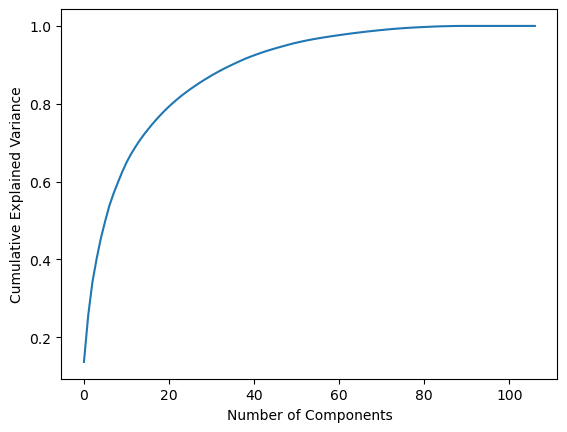

In [15]:
# Determine the number of appropriate components for PCA (scaled (combined) data)
compute_pca(complete_df)

### Determine the number of clusters for this dataset ###

In [16]:
# Use KMedoids and compute Davies-Bouldin scores, elbow curve, and silhouette scores to determine the optimal number of clusters.
def compute_cluster_metrics(data_in, n_clusters):
    """
    Function to compute cluster metrics for a given number of clusters.
    This function will be called in parallel.
    """
    # Initialize the clusterer with n_clusters value and random state for reproducibility
    clusterer = KMedoids(n_clusters=n_clusters, init='k-medoids++', random_state=42)
    cluster_labels = clusterer.fit_predict(data_in)
    
    # Compute the scores for various metrics
    davies_bouldin = davies_bouldin_score(data_in, cluster_labels)
    inertia = clusterer.inertia_
    silhouette_avg = silhouette_score(data_in, cluster_labels)
    
    return n_clusters, davies_bouldin, inertia, silhouette_avg
    
def compute_clusters_parallel(data_in, max_clusters, n_jobs=-1):
    # Parallel computation of the cluster metrics for each number of clusters from 2 to max_clusters
    parallel = Parallel(n_jobs=n_jobs)
    cluster_metrics_list = parallel(delayed(compute_cluster_metrics)(data_in, n_clusters)
                                    for n_clusters in range(2, max_clusters + 1))

    # Creating a DataFrame to store the clustering metrics
    cluster_metrics_df = pd.DataFrame(cluster_metrics_list,
                                      columns=['Num_Clusters', 'Davies_Bouldin', 'Inertia', 'Silhouette_Avg'])

    return cluster_metrics_df

In [17]:
# Create a DataFrame of the results for further analysis downstream - Compute clusters for the complete dataframe
non_pca_cluster_scores_df = compute_clusters_parallel(data_in=complete_df, max_clusters=45, n_jobs=-1)

In [18]:
# Function to perform PCA for the provided data
def perform_pca(input_data, name, n_comp):
    pca = PCA(n_components=n_comp, random_state=42)
    pca_out = pca.fit_transform(input_data)

    # Create a DataFrame with the principal components.
    columnz =[]

    for i in range(1,n_comp+1):
        columnz.append(name + '_pc'+str(i))
    
    out_df = pd.DataFrame(data=pca_out, columns=columnz)

    out_df['Country_Year'] = ori_df['Country_Year']
    out_df = out_df.reset_index(drop=True)
    out_df = out_df.set_index('Country_Year')
    return out_df

In [19]:
# Perform PCA on the complete_df, then analyze to determine the correct number of clusters.
complete_pca_df = perform_pca(complete_df, 'Complete', 6)

In [20]:
# Create a DataFrame of the results for further analysis downstream - Compute clusters for the complete dataframe with PCA
pca_cluster_scores_df= compute_clusters_parallel(data_in=complete_pca_df, max_clusters=45, n_jobs=-1)

In [21]:
pca_cluster_scores_df

,Num_Clusters,Davies_Bouldin,Inertia,Silhouette_Avg
0,2,2.053892,7270.994097,0.204905
1,3,1.698780,6682.453597,0.189365
2,4,1.354187,5551.792723,0.281151
3,5,1.194453,4901.463353,0.314041
4,6,1.067008,4346.452087,0.372891
5,7,1.042345,4158.094724,0.360085
6,8,1.221501,4076.373032,0.345755
7,9,1.135767,3735.440682,0.378011
8,10,1.167003,3600.340801,0.382204
9,11,1.152024,3449.570505,0.397515


In [22]:
pca_cluster_scores_df.hvplot.scatter(x='Num_Clusters', y='Davies_Bouldin')

:Scatter   [Num_Clusters]   (Davies_Bouldin)

In [23]:
pca_cluster_scores_df.hvplot.scatter(x='Num_Clusters', y='Silhouette_Avg')

:Scatter   [Num_Clusters]   (Silhouette_Avg)

In [24]:
# define the model
cluster_model = KMedoids(n_clusters=44, init='k-medoids++', random_state=42)

# Fit the model and predict labels
cluster_model.fit_predict(complete_pca_df)

# Add the predicted class columns to the visualization dataset
viz_df['Cluster Label'] = cluster_model.labels_

In [25]:
# Add the Country_Year column to the dataframe, then run the profiling report
viz_df['Country-Year'] = viz_df.index

### Principal Feature Analysis ###

In [26]:
non_pca_cluster_scores_df

,Num_Clusters,Davies_Bouldin,Inertia,Silhouette_Avg
0,2,2.881699,12138.871273,0.114205
1,3,2.451830,10906.403988,0.140319
2,4,2.746803,10701.459863,0.099398
3,5,2.534535,10375.283359,0.115931
4,6,2.360815,9765.984376,0.120841
5,7,2.405767,9682.253750,0.114266
6,8,2.227757,9259.861383,0.152694
7,9,2.126682,9081.717131,0.157622
8,10,2.203196,8992.430378,0.157735
9,11,2.173531,8898.519240,0.160250


In [27]:
pca_cluster_scores_df

,Num_Clusters,Davies_Bouldin,Inertia,Silhouette_Avg
0,2,2.053892,7270.994097,0.204905
1,3,1.698780,6682.453597,0.189365
2,4,1.354187,5551.792723,0.281151
3,5,1.194453,4901.463353,0.314041
4,6,1.067008,4346.452087,0.372891
5,7,1.042345,4158.094724,0.360085
6,8,1.221501,4076.373032,0.345755
7,9,1.135767,3735.440682,0.378011
8,10,1.167003,3600.340801,0.382204
9,11,1.152024,3449.570505,0.397515


### Define functions to select dataset features that provide relevant information for clustering. 
### Only important features are used to compute clusters.

In [28]:
# Define the prefilter function
def prefilter_features(df, threshold=0.008):
    """
    Prefilter features with low variance.
    """
    # Threshold can be set according to domain knowledge or exploratory analysis
    selector = VarianceThreshold(threshold)
    selector.fit(df)
    
    # Return the dataframe with selected features
    return df[df.columns[selector.get_support(indices=True)]]
    

In [29]:
# Calculate entropy
def calculate_entropy(labels):
    value, counts = np.unique(labels, return_counts=True)
    return entropy(counts, base=2)


In [30]:
# Silhouette score adjusted by entropy
def clustering_score(df, n_clusters):
    model = KMedoids(n_clusters=n_clusters, init='k-medoids++', random_state=42)
    labels = model.fit_predict(df)
    silhouette_avg = silhouette_score(df, labels)
    entropy_score = calculate_entropy(labels)
    return silhouette_avg / entropy_score


In [31]:
# Function to evaluate clusters with a set of features removed
def evaluate_feature_set(df, features_to_exclude, n_clusters):
    features_to_try = df.columns.difference(features_to_exclude)
    if len(features_to_try) == 0:
        return -1, [], n_clusters
    score = clustering_score(df[features_to_try], n_clusters)
    return score, features_to_try, n_clusters
    

In [32]:
# Principal Feature Analysis with parallel processing
def select_features_and_cluster_parallel(df, max_clusters=45, n_jobs=-1):
    # Prefilter features based on variance
    df_prefiltered = prefilter_features(df)
    
    # Calculate initial score with all features
    initial_score, _, _ = evaluate_feature_set(df, [], 2)

    # Convert to list for indexing
    features_list = df_prefiltered.columns.tolist()
    
    num_features = len(features_list)
    selected_features = list(features_list)
    current_score = initial_score
    #current_score = -1
    best_score = initial_score
    #best_score = -1
    best_features = list(features_list)
    best_k = 2
    improvement = True

    # Parallel computation setup
    parallel = Parallel(n_jobs=n_jobs)

    while improvement and len(selected_features) > 1:
        improvement = False
        
        # This will generate a list of (score, feature_subset, k) for all combinations
        scores_features_k = parallel(delayed(evaluate_feature_set)(df_prefiltered, [f], k)
                                     for f in selected_features for k in range(2, max_clusters + 1))
        # Check if the list is not empty to avoid ValueError
        if not scores_features_k:
            break
                    
        # Find the best score, corresponding feature set and k
        best_score, best_features, best_k = max(scores_features_k, key=lambda item: (item[0], -len(item[1])))

        if best_score > current_score:
            current_score = best_score
            improvement = True
        
        # Remove one feature (with the worst score) at a time for the next round
        scores_features = sorted(scores_features_k, key=lambda item: item[0])
        if scores_features:  # Check if there are features scored
            lowest_score, worst_features, _ = scores_features[0]
            if worst_features[0] in selected_features:
                selected_features.remove(worst_features[0])  # Remove worst feature for the next iteration

        final_score = best_score - initial_score

    # Output results
    print(f'Total score improvement = best score:{best_score} - initial score:{initial_score} = final score:{final_score}')
    print("Best number of clusters:", best_k)
    print("Best subset of features by index:", best_features)
    return best_k, best_features
    

In [33]:
# Run the experiment using the complete (non-pca) dataframe
best_k, best_features = select_features_and_cluster_parallel(complete_df)

Total score improvement = best score:0.13202281325847776 - initial score:0.12463438892628767 = final score:0.0073884243321900855
Best number of clusters: 2
Best subset of features by index: Index(['Alcohol Use per capita (liters)', 'Avg Rainfall (mm/yr)',
       'Capital HE (% GDP)', 'Current HE (% GDP)',
       'Current HE per capita (PPP Intl $)', 'Daily Caloric Supply',
       'Doctors (#/10k pop)', 'Domestic General Gov HE (% GDP)',
       'Domestic General Gov HE per capita (PPP Intl $)',
       'Electricity Access (% Pop)', 'Employer-liability system',
       'Employer-liability system (cash benefits)',
       'Employer-liability system (cash maternity benefits)',
       'Employer-liability system (cash medical benefits)',
       'Employer-liability system (cash sickness benefits)',
       'Employer-liability system (maternity benefits)',
       'Employer-liability system (medical benefits)',
       'Employer-liability system (paternity benefits)',
       'Employer-liability syst

In [34]:
# Use the selected features for the final clustering
final_df = complete_df[best_features].copy()

# Perform clustering on the final set of features
final_cluster_model = KMedoids(n_clusters=best_k, init='k-medoids++', random_state=42)
final_cluster_labels = final_cluster_model.fit_predict(final_df)

# Create the dataframes for visualization - Add cluster labels to the dataframes
final_viz_df = viz_df[best_features].copy()
final_viz_df['Cluster Label'] = final_cluster_labels
#final_viz_df['Country_Year'] = viz_df.index

# Add the cluster labels to the (complete) viz dataframe
viz_df['Cluster Label'] = final_cluster_labels
#viz_df['Country_Year'] = viz_df.index

In [35]:
# Create YData reports to explore the feature relationships
final_report = ProfileReport(final_viz_df, config_file="config_ELR.yml")
final_report.to_file('Final_Reduced_Report.html')

viz_report = ProfileReport(viz_df, config_file="config_ELR.yml")
viz_report.to_file('Final_Complete_Report.html')

#comparison_report = final_report.compare(viz_report)
#comparison_report.to_file('Comparison.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\AZ\anaconda3\envs\py3.11\Lib\site-packages\ydata_profiling\model\correlations.py:66: UserWarning: There was an attempt to calculate the pearson correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"pearson": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: 'Albania_1990'')
  warnings.warn(
C:\Users\AZ\anaconda3\envs\py3.11\Lib\site-packages\ydata_profiling\model\pandas\duplicates_pandas.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  .reset_index(name=duplicates_key)
C:\Users\AZ\anaconda3\envs\py3.11\Lib\site-packages\yda

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
stop = time.perf_counter()

print(f"Execution in {stop - start:0.4f} seconds")

In [36]:
viz_df

,SSS Depth,Avg Rainfall (mm/yr),Pop Density (#/sq km),Total Population (M),Total Labor Force (M),LEx years,Doctors (#/10k pop),Electricity Access (% Pop),Current HE (% GDP),Current HE per capita (PPP Intl $),...,Universal (cash parental grants),Universal (paid parental leave),Universal (parental benefits),Universal (pregnancy grant),Universal (prenatal care grant),Universal medical benefits,Voluntary community-based social insurance system (medical benefits),Voluntary pension scheme,Cluster Label,Country-Year
Country_Year,,,,,,,,,,,,,,,,,,,,,
Albania_1990,2,1485.0,119.946788,3.286542,1.374478,73.144,13.71,100.000000,5.944186,222.786533,...,0,0,0,0,0,1,0,0,1,Albania_1990
Albania_1991,2,1485.0,119.225912,3.266790,1.429833,73.378,14.52,100.000000,5.944186,222.786533,...,0,0,0,0,0,1,0,0,1,Albania_1991
Albania_1992,2,1485.0,118.505073,3.247039,1.438342,73.715,15.93,100.000000,5.944186,222.786533,...,0,0,0,0,0,1,0,0,1,Albania_1992
Albania_1993,2,1485.0,117.784197,3.227287,1.413557,73.939,13.68,100.000000,5.944186,222.786533,...,0,0,0,0,0,1,0,0,1,Albania_1993
Albania_1994,2,1485.0,117.063358,3.207536,1.391914,74.131,12.85,100.000000,5.944186,222.786533,...,0,0,0,0,0,1,0,0,1,Albania_1994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zimbabwe_2018,1,657.0,38.909614,15.052184,5.770226,61.414,2.01,45.400288,4.670418,180.091128,...,0,0,0,0,0,0,0,0,0,Zimbabwe_2018
Zimbabwe_2019,1,657.0,39.691374,15.354608,5.912685,61.292,1.95,46.682095,3.659765,132.068691,...,0,0,0,0,0,0,0,0,0,Zimbabwe_2019
Zimbabwe_2020,1,657.0,40.505793,15.669666,6.008633,61.124,1.89,52.747667,3.425581,118.127063,...,0,0,0,0,0,0,0,0,0,Zimbabwe_2020


### Write Results to Project Database ###

In [ ]:
# load the config from the .env file
load_dotenv()
MONGODB_URI = os.environ['MONGODB_URI']

# Connect to the database engine
client = MongoClient(MONGODB_URI)

# connect to the project db
db = client['ExpectLifeRedux']

# get a reference to the data collection
perf_data = db['Supervised_Performance_Data']

In [ ]:
# Create a dictionary to send to MongoDB - Alternate method, not necessary when using PyMongoArrow
perf_dict = performance_df.to_dict('records')
print(perf_dict)

# write the data to the database (alternate method)
perf_data.insert_many(perf_dict)